In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2025 United Kingdom Research and Innovation
#  Copyright 2025 The University of Manchester
#  Copyright 2025 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Hannah Robarts (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Margaret Duff (UKRI-STFC)

# HDF5 reader - ESRF example 

This is taken from the CIL deep dive [05_esrf_pipeline.ipynb](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/4_Deep_Dives/05_esrf_pipeline.ipynb). All credit should go to those authors. 

It is a work in progress.



## Data format: NXTomo

This example uses dataset tomo_00065 from the TomoBank [[1](https://iopscience.iop.org/article/10.1088/1361-6501/aa9c19)] multidistance dataset. The sample is a steel sphere measured at various propagation distances to demonstrate the effect of propagation based phase contrast imaging.

The tomo_00065.h5 dataset can be retrieved from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance using:

`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00065.h5`

[1] De Carlo, Francesco, et al. “TomoBank: a tomographic data repository for computational x-ray science.” Measurement Science and Technology 29.3 (2018): 034004. http://www.doi.org/10.1088/1361-6501/aa9c19

In [2]:
# CIL methods
from cil.framework import DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import Normaliser, RingRemover, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP
# Additional packages
import numpy as np # conda install numpy
import matplotlib.pyplot as plt # conda install matplotlib
# Custom methods
from hdf5_parallel_reader.hdf5_parallel_reader import HDF5_ParallelDataReader

## CIL Version

This notebook was developed using CIL v25.0.0

Update this filepath to where you have saved the dataset:

In [3]:
filename = 'tomo_00065.h5'
HDF5_utilities.print_metadata(filename)

	 - exchange : <HDF5 group "/exchange" (5 members)>
		 - data : <HDF5 dataset "data": shape (450, 650, 350), type "<u2">
				 - axes : theta:y:x
				 - description : transmission
				 - units : counts
		 - data_dark : <HDF5 dataset "data_dark": shape (2, 650, 350), type "<u2">
				 - axes : theta_dark:y:x
				 - units : counts
		 - data_white : <HDF5 dataset "data_white": shape (4, 650, 350), type "<u2">
				 - axes : theta_white:y:x
				 - units : counts
		 - theta : <HDF5 dataset "theta": shape (450,), type "<f8">
				 - units : degrees
		 - title : <HDF5 dataset "title": shape (), type "|O">
	 - implements : <HDF5 dataset "implements": shape (), type "|O">
	 - measurement : <HDF5 group "/measurement" (2 members)>
		 - instrument : <HDF5 group "/measurement/instrument" (4 members)>
			 - acquisition : <HDF5 group "/measurement/instrument/acquisition" (2 members)>
				 - comment : <HDF5 dataset "comment": shape (), type "|O">
				 - mode : <HDF5 dataset "mode": shape (), type "|O">
		

Configure paths to the relevant data and metadata in the file, then read the data using the generic 'HDF5_ParallelDataReader'


In [4]:
reader = HDF5_ParallelDataReader(filename, 
                                 dataset_path=('exchange/data'),
                                 distance_units='mm', angle_units='degree')

reader.configure_angles(angles_path='exchange/theta', HDF5_units='degree')

reader.configure_pixel_sizes('measurement/instrument/detector/x_actual_pixel_size',
                             'measurement/instrument/detector/y_actual_pixel_size',
                             HDF5_units = 'um')

reader.configure_normalisation_data(flatfield_path='exchange/data_white',
                                    darkfield_path='exchange/data_dark')

reader.configure_sample_detector_distance(sample_detector_distance=58, HDF5_units='mm') # required for phase retrieval

data = reader.read()

energy = HDF5_utilities.read(filename, 'measurement/instrument/monochromator/energy') # required for phase retrieval

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0., 58.,  0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [350 650]
	Pixel size: [0.0499 0.0499]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 450
	Angles 0-9 in degrees: [0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2]
	Angles 440-449 in degrees: [352. , 352.8, 353.6, 354.4, 355.2, 356. , 356.8, 357.6, 358.4, 359.2]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm
Shape out:  (450, 650, 350)


In [5]:
islicer(data)


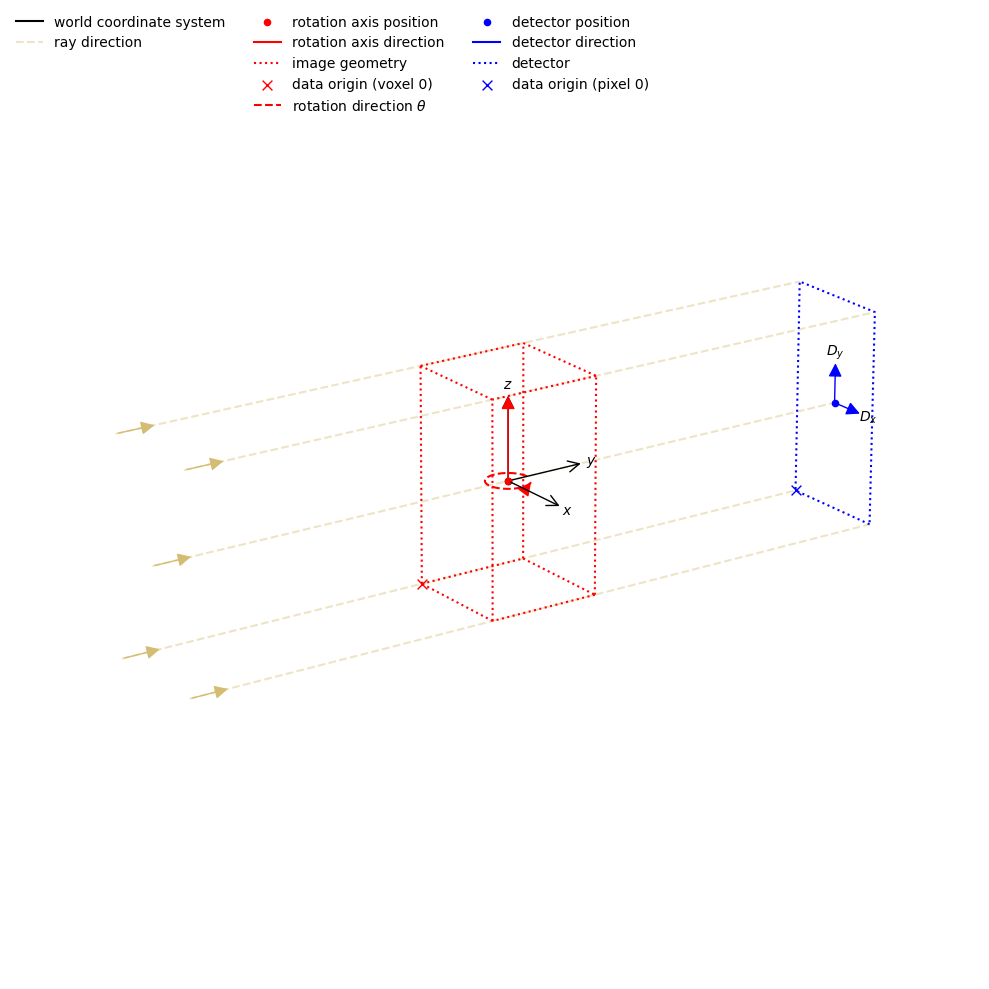

In [6]:

show_geometry(data.geometry)

Normalise using the CIL normaliser with the flat and dark fields from the reader 

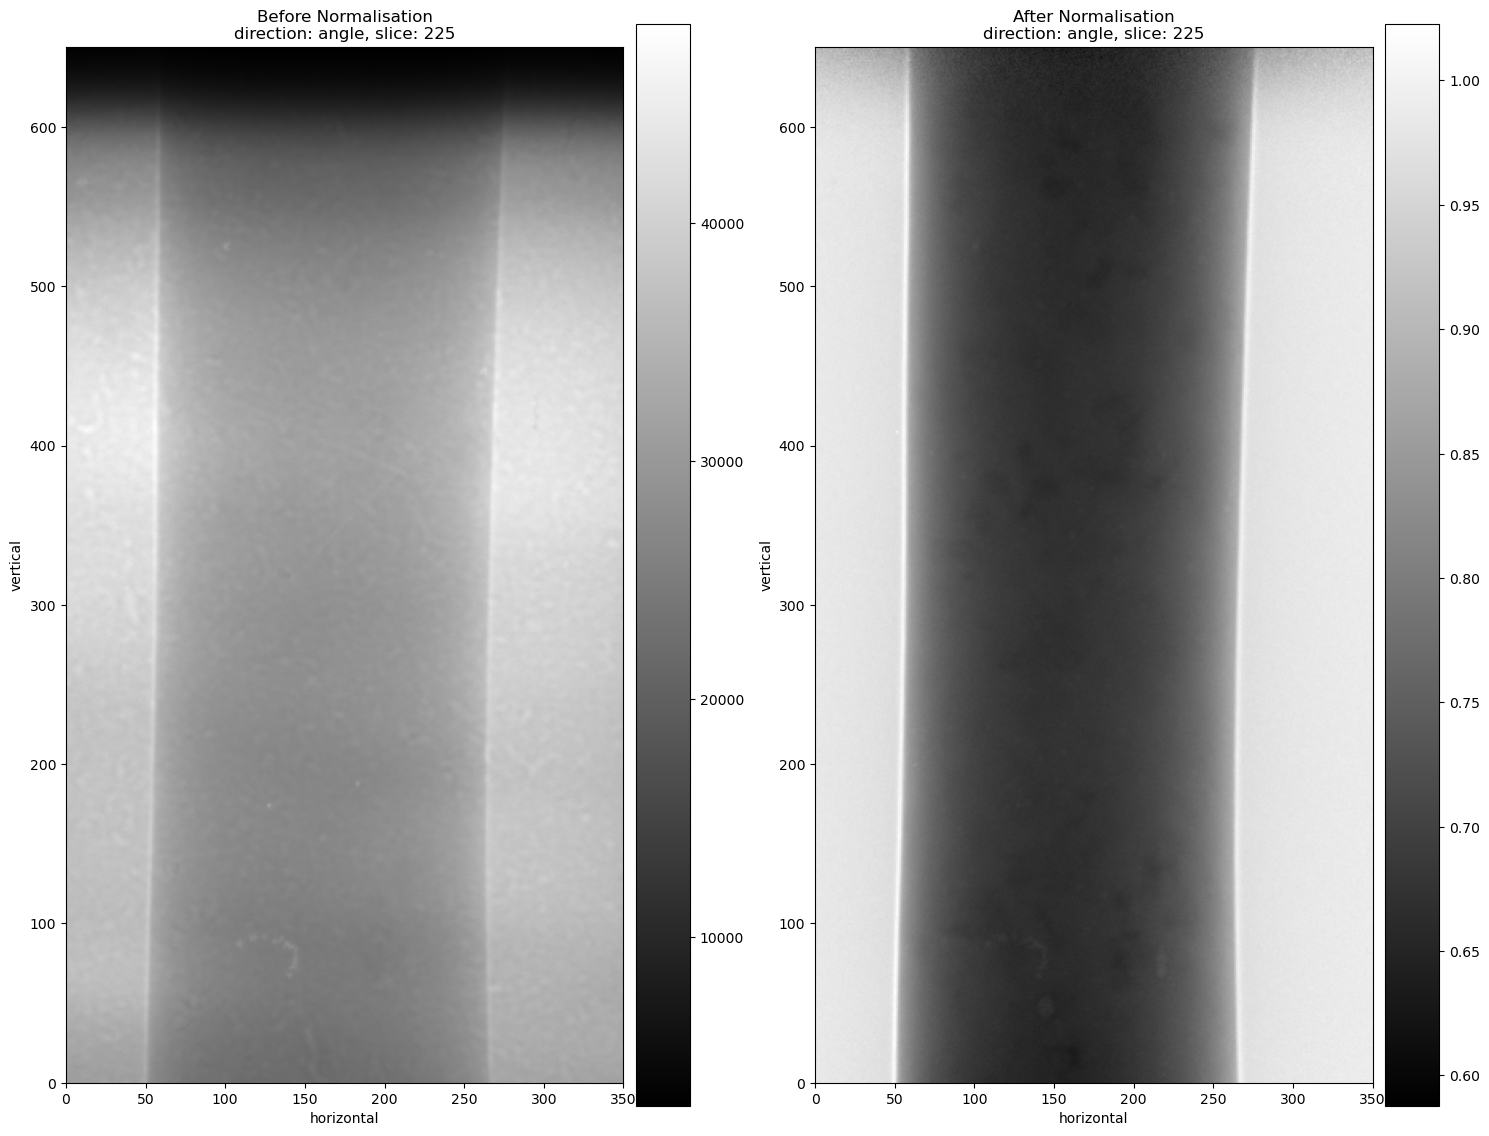

In [7]:
processor = Normaliser(flat_field=np.mean(reader.flatfield.array, axis = 0), dark_field=np.mean(reader.darkfield.array, axis = 0))
processor.set_input(data)
data_test = processor.get_output()

# Use the show2D method to check the effect of the normalisation
show2D([data, data_test],
       title=['Before Normalisation', 'After Normalisation'])